In [1]:
import numpy as np
import pandas as pd

# Loading MLflow libraries
import mlflow
from mlflow.models.signature import infer_signature
from lightgbm import LGBMClassifier

# Loading packages for building a Machine Learning pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Loading libraries for visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as display
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

from synapse.ml.lightgbm import LightGBMClassifier
from synapse.ml.automl import TuneHyperparameters
from synapse.ml.train import ComputeModelStatistics
from synapse.ml.predict import MLFlowTransformer
import lightgbm as lgb

from synapse.ml.train import TrainClassifier
from pyspark.ml.classification import (
    LogisticRegression,
    RandomForestClassifier,
    GBTClassifier
)

from synapse.ml.automl import *

print("All Modules Loaded")

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 3, Finished, Available)

All Modules Loaded


In [23]:
df = spark.sql("SELECT * FROM lakehousebronze.fraud_final")

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 26, Finished, Available)

In [26]:
df = df.toPandas()

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 29, Finished, Available)

In [49]:
EXPERIMENT_NAME = "frauddetection"
MODEL_NAME = "fraud_model"
TARGET_COL = "label"

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 52, Finished, Available)

In [28]:
df = df.astype({'accountCountryRisk': 'float32'})
df = df.astype({'accountPostalCodeRisk': 'float32'})
df = df.astype({'accountStateRisk': 'float32'})
df = df.astype({'browserLanguageRisk': 'float32'})
df = df.astype({'ipCountryCodeRisk': 'float32'})
df = df.astype({'ipPostCodeRisk': 'float32'})
df = df.astype({'ipStateRisk': 'float32'})
df = df.astype({'localHourRisk': 'float32'})
df = df.astype({'paymentBillingCountryCodeRisk': 'float32'})
df = df.astype({'paymentBillingPostalCodeRisk': 'float32'})
df = df.astype({'transactionCurrencyCodeRisk': 'float32'})
df = df.astype({'paymentBillingStateRisk': 'float32'})
df = df.astype({'sumPurchaseAmount1dPerUser': 'float32'})
df = df.astype({'sumPurchaseAmount30dPerUser': 'float32'})

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 31, Finished, Available)

In [29]:
df_clean = df[[
'label'                                     ,
'txDayOfWeek'                                  ,
'transactionAmountUSD'                         ,
'digitalItemCount'                             ,
'physicalItemCount'                            ,
'accountAge'                                   ,
'paymentInstrumentAgeInAccount'                ,
'numPaymentRejects1dPerUser'                   ,
'accountCountryRisk'                           ,
'accountPostalCodeRisk'                        ,
'accountStateRisk'                             ,
'browserLanguageRisk'                          ,
'ipCountryCodeRisk'                            ,
'ipPostCodeRisk'                               ,
'ipStateRisk'                                  ,
'localHourRisk'                                ,
'paymentBillingCountryCodeRisk'                ,
'paymentBillingPostalCodeRisk'                 ,
'paymentBillingStateRisk'                      ,
'transactionCurrencyCodeRisk'                  ,
'isProxyIP'                                     ,
'paymentInstrumentType'                         ,
'cardType'                                      ,
'isUserRegistered'                              ,
'isHighAmount'                                  ,
'acctBillingAddressMismatchFlag'                ,
'acctBillingPostalCodeMismatchFlag'             ,
'acctBillingCountryMismatchFlag'                ,
'acctBillingNameMismatchFlag'                   ,
'acctShippingAddressMismatchFlag'               ,
'shippingBillingAddressMismatchFlag'          ,
'sumPurchaseCount1dPerUser',
'sumPurchaseAmount1dPerUser',
'sumPurchaseCount30dPerUser',
'sumPurchaseAmount30dPerUser' ]]

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 32, Finished, Available)

In [30]:
df_clean.dtypes

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 33, Finished, Available)

label                                   int32
txDayOfWeek                             int32
transactionAmountUSD                  float32
digitalItemCount                      float32
physicalItemCount                     float32
accountAge                            float32
paymentInstrumentAgeInAccount         float32
numPaymentRejects1dPerUser            float32
accountCountryRisk                    float32
accountPostalCodeRisk                 float32
accountStateRisk                      float32
browserLanguageRisk                   float32
ipCountryCodeRisk                     float32
ipPostCodeRisk                        float32
ipStateRisk                           float32
localHourRisk                         float32
paymentBillingCountryCodeRisk         float32
paymentBillingPostalCodeRisk          float32
paymentBillingStateRisk               float32
transactionCurrencyCodeRisk           float32
isProxyIP                              object
paymentInstrumentType             

In [32]:
pdf = df_clean
X= pd.get_dummies(pdf.drop(['label'],axis=1),drop_first=True, dtype='int64')
y= pdf['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 35, Finished, Available)

In [33]:
X_train.head(4)

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 36, Finished, Available)

,txDayOfWeek,transactionAmountUSD,digitalItemCount,physicalItemCount,accountAge,paymentInstrumentAgeInAccount,numPaymentRejects1dPerUser,accountCountryRisk,accountPostalCodeRisk,accountStateRisk,...,isUserRegistered_28,isUserRegistered_322,isUserRegistered_4,isUserRegistered_44,isUserRegistered_72,isUserRegistered_FALSE,isUserRegistered_TRUE,isHighAmount_1,acctBillingPostalCodeMismatchFlag_1,acctBillingCountryMismatchFlag_1
125448,7,480.429993,0.0,1.0,1.0,0.000000,0.0,-4.881638,-2.261763,-4.432244,...,0,0,0,0,0,1,0,1,0,0
7483,5,146.990005,1.0,0.0,1.0,0.000694,0.0,-4.881638,-2.332144,-3.644737,...,0,0,0,0,0,1,0,0,0,0
121135,3,161.722519,1.0,1.0,1.0,0.000000,0.0,-3.356897,-2.208274,-6.484622,...,0,0,0,0,0,1,0,1,0,0
187886,2,399.989990,1.0,0.0,1.0,0.000000,0.0,-4.881638,-2.351375,-4.882737,...,0,0,0,0,0,1,0,1,0,0


In [34]:
lgb_model = LGBMClassifier(   
bagging_fraction=1.0, bagging_freq=7, 
boosting_type='gbdt',
colsample_bytree=1.0, feature_fraction=0.4, 
importance_type='split', learning_rate=0.05, 
min_child_samples=71, isUnbalance=True,
)

lgb_model

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 37, Finished, Available)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=7, feature_fraction=0.4,
               isUnbalance=True, learning_rate=0.05, min_child_samples=71)

In [35]:
print(f"\n\nTraining using the train dataset Started:\n")
fraud_model = lgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[
        lgb.log_evaluation(10),
    ],
)

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 38, Finished, Available)



Training using the train dataset Started:

[LightGBM] [Warning] Unknown parameter: isUnbalance
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Unknown parameter: isUnbalance
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 803, number of negative: 138843
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testin

2024-01-15:02:32:27,904 WARNING  [tracking_store.py:153] log_inputs not supported


StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 39, Finished, Available)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

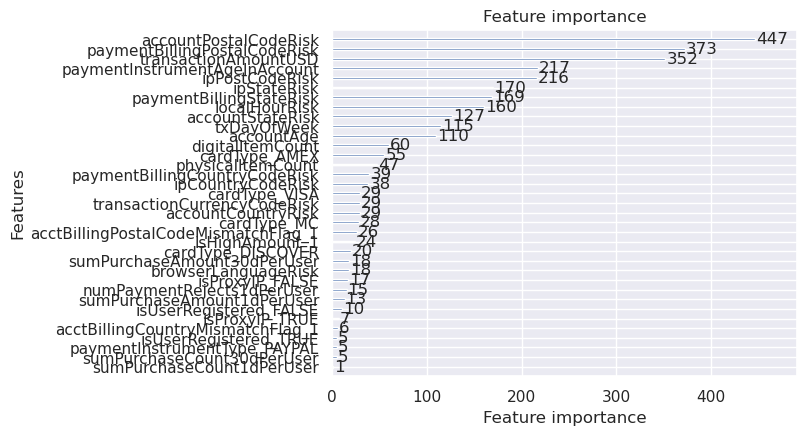

In [36]:
lgb.plot_importance(fraud_model)

In [37]:
TARGET_COL = "label"
feature_cols = [c for c in X_test.columns.tolist() if c not in [TARGET_COL]]

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 40, Finished, Available)

In [38]:
def prediction_to_spark(model, test):
    feature_cols = [c for c in test.columns.tolist() if c not in [TARGET_COL]]
    predictions = model.predict(test[feature_cols], num_iteration=model.best_iteration_)
    predictions = tuple(zip(test[TARGET_COL].tolist(), predictions.tolist()))
    dataColumns = [TARGET_COL, "prediction"]
    predictions = (
        spark.createDataFrame(data=predictions, schema=dataColumns)
        .withColumn(TARGET_COL, col(TARGET_COL).cast(IntegerType()))
        .withColumn("prediction", col("prediction").cast(DoubleType()))
    )

    return predictions

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 41, Finished, Available)

In [39]:
train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis=1)
processed_df = pd.concat([train,test])

pred = prediction_to_spark(fraud_model, processed_df)
predictions = pred.toPandas()
predictions = predictions.drop(['label'],axis=1)
new_df = pd.concat([pdf,predictions],axis=1)

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 42, Finished, Available)

[LightGBM] [Warning] Unknown parameter: isUnbalance
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


2024-01-15:02:33:06,126 WARNING  [tracking_store.py:153] log_inputs not supported


In [40]:
metrics = ComputeModelStatistics(
    evaluationMetric="classification", labelCol=TARGET_COL, scoredLabelsCol="prediction"
).transform(pred)

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 43, Finished, Available)

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 44, Finished, Available)

[[1.98264e+05 6.20000e+01]
 [5.76000e+02 5.93000e+02]]


Text(41.25, 0.5, 'True label')

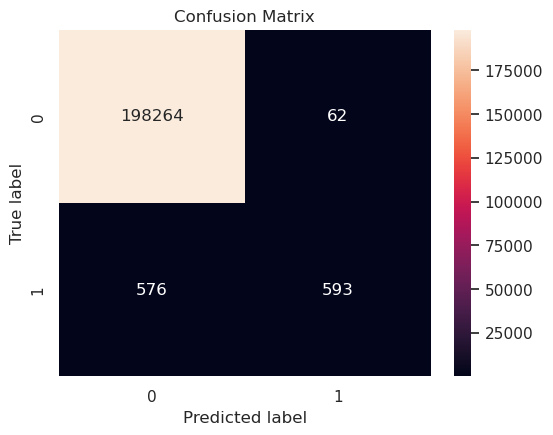

In [41]:
cm = metrics.select("confusion_matrix").collect()[0][0].toArray()
print(cm)
sns.set(rc={"figure.figsize": (6, 4.5)})
ax = sns.heatmap(cm, annot=True, fmt=".20g")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

In [42]:
def evaluate(predictions):
    """
    Evaluate the model by computing AUROC and AUPRC with the predictions.
    """
    # initialize the binary evaluator
    evaluator = BinaryClassificationEvaluator(
        rawPredictionCol="prediction", labelCol=TARGET_COL)
    _evaluator = lambda metric: evaluator.setMetricName(metric).evaluate(predictions)

    # calculate AUROC, baseline 0.5
    auroc = _evaluator("areaUnderROC")
    print(f"AUROC: {auroc:.4f}")
    
    # calculate AUPRC, baseline positive rate (0.172% in the demo data)
    auprc = _evaluator("areaUnderPR")
    print(f"AUPRC: {auprc:.4f}")
    return auroc, auprc

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 45, Finished, Available)

In [43]:
auroc, auprc = evaluate(pred)

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 46, Finished, Available)

AUROC: 0.7535
AUPRC: 0.6837


In [51]:
signature = infer_signature(
    X_test,
    np.array(
        fraud_model.predict(X_test, num_iteration=fraud_model.best_iteration_),
        dtype="int_",
    ),
)

mlflow.set_experiment(EXPERIMENT_NAME)

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 54, Finished, Available)

[LightGBM] [Warning] Unknown parameter: isUnbalance
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


2024-01-15:02:39:53,922 WARNING  [tracking_store.py:153] log_inputs not supported
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/models/signature.py:214: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


<Experiment: artifact_location='', creation_time=1705198890201, experiment_id='fc505efc-7b94-41c9-b02d-553936e01bbe', last_update_time=None, lifecycle_stage='active', name='frauddetection', tags={}>

In [52]:
# log model, metrics and params
raw_model_info = [fraud_model, auprc, auroc]
data_enhancements = ["None", "SMOTE"]
for idx, info in enumerate([raw_model_info]):
    model, auprc, auroc = info
    with mlflow.start_run(nested=True) as run:
        print("log model:")
        mlflow.lightgbm.log_model(
            model,
            f"{MODEL_NAME}",
            registered_model_name=f"{MODEL_NAME}",
            signature=signature,
        )
        print("log metrics:")
        mlflow.log_metrics({"AUPRC": auprc, "AUROC": auroc})
        
        model_uri = f"runs:/{run.info.run_id}/{MODEL_NAME}"
        print("Model saved in run %s" % run.info.run_id)
        print(f"Model URI: {model_uri}")

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 55, Finished, Available)

log model:
log metrics:
Model saved in run e26f7f67-108f-486d-9184-8523e1c7fe4f
Model URI: runs:/e26f7f67-108f-486d-9184-8523e1c7fe4f/fraud_model


Successfully registered model 'fraud_model'.
2024/01/15 02:40:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: fraud_model, version 1
Created version '1' of model 'fraud_model'.


In [55]:
spark.conf.set("spark.synapse.ml.predict.enabled", "true")

model = MLFlowTransformer(
    inputCols=feature_cols,
    outputCol="prediction",
    modelName=f"{MODEL_NAME}",
    modelVersion=1,
)
print(model)

test_df = spark.createDataFrame(data=test, schema=test.columns.to_list())
batch_predictions = model.transform(test_df)
batch_predictions.toPandas()

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 58, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.


MLFlowTransformer_ce895b687b62


,txDayOfWeek,transactionAmountUSD,digitalItemCount,physicalItemCount,accountAge,paymentInstrumentAgeInAccount,numPaymentRejects1dPerUser,accountCountryRisk,accountPostalCodeRisk,accountStateRisk,...,isUserRegistered_4,isUserRegistered_44,isUserRegistered_72,isUserRegistered_FALSE,isUserRegistered_TRUE,isHighAmount_1,acctBillingPostalCodeMismatchFlag_1,acctBillingCountryMismatchFlag_1,label,prediction
0,6,151.190002,1.0,0.0,1.0,0.000000,0.0,-4.881638,-2.397895,-4.952675,...,0,0,0,1,0,1,0,0,0,0
1,2,72.519997,1.0,0.0,2000.0,0.000000,0.0,-4.881638,-2.208274,-4.759966,...,0,0,0,1,0,0,1,1,0,0
2,1,5.330000,1.0,0.0,1887.0,664.081970,0.0,-4.881638,-2.477938,-5.714466,...,0,0,0,1,0,0,1,0,0,0
3,2,5.300000,1.0,0.0,2000.0,458.802094,0.0,-4.881638,-2.240710,-5.200620,...,0,0,0,1,0,0,0,0,0,0
4,4,79.989998,1.0,0.0,1.0,0.000000,0.0,-4.881638,-2.251292,-5.824325,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59844,4,151.539993,1.0,0.0,1.0,0.039583,8.0,-4.881638,-2.585711,-5.015604,...,0,0,0,1,0,1,0,0,0,0
59845,6,572.485840,0.0,1.0,1.0,0.004167,1.0,-4.753702,-2.240710,-4.374498,...,0,0,0,1,0,1,1,0,0,0
59846,7,106.476196,1.0,0.0,1.0,0.000000,0.0,-6.397460,-2.219203,-6.484622,...,0,0,0,1,0,0,0,0,0,0
59847,7,152.940002,1.0,0.0,7.0,0.008333,1.0,-4.881638,-2.388763,-4.732819,...,0,0,0,1,0,1,0,0,0,0


StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 59, Finished, Available)

In [56]:
# Delta table
table_name = 'lakehousebronze.fraud_predicteddata'
batch_predictions.write.mode("overwrite").option("overwriteSchema", "true").format("delta").saveAsTable(table_name)

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 60, Finished, Available)